# Custom GP modeling for BO

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from xopt.vocs import VOCS

my_vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)


<Axes: >

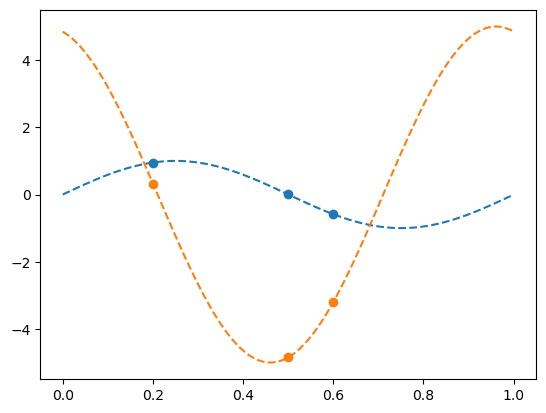

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return 5.0*torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(my_vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

training_data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Custom Model definition
In this example we know that the target optimization function is periodic, so it
makes sense to use a periodic kernel for the GP model with no noise. Here we define a
function to create that model. Note that we can use helper functions provided by Xopt to
compose parts model (in this case a standard GP model for the constraints).

In [3]:
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.kernels import PeriodicKernel, ScaleKernel

class CustomModelConstructor(StandardModelConstructor):
    def build_model(self, data: pd.DataFrame, tkwargs: dict = None):
        # set tkwargs
        tkwargs = tkwargs or {"dtype": torch.double, "device": "cpu"}

        # drop nans
        valid_data = data[
            pd.unique(self.vocs.variable_names + self.vocs.output_names)
        ].dropna()

        # get data
        input_data, objective_data, constraint_data = self.vocs.extract_data(valid_data)
        train_X = torch.tensor(input_data.to_numpy(), **tkwargs)
        self.input_transform.to(**tkwargs)
        self.likelihood.to(**tkwargs)

        # specify periodic kernel for both objective functions and constraints
        covar_module = ScaleKernel(PeriodicKernel())

        return self.build_standard_model(
            train_X,
            objective_data,
            constraint_data,
            tkwargs,
            covar_module = covar_module
        )

# Create generator using the custom model

In [4]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions

# note the creation of options beforehand
model_options = ModelOptions(custom_constructor=CustomModelConstructor)
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(my_vocs, options=generator_options)

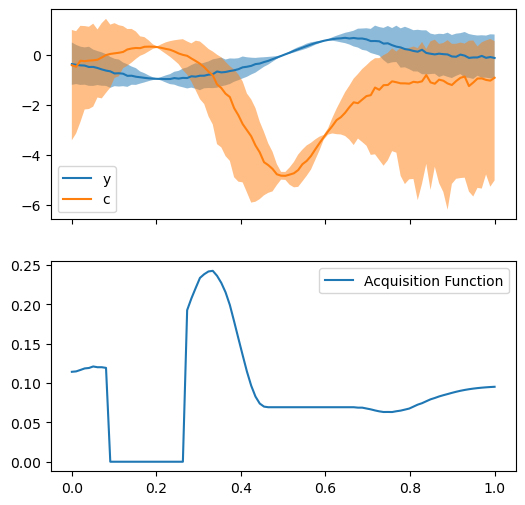

In [5]:
# view custom model from data
generator.add_data(training_data)
model = generator.train_model()

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    n_samples = torch.Size([512])
    for i in range(len(post.posteriors)):
        mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
        l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
        u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
        ax[0].plot(test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
    ax[0].legend()

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

In [6]:
# get the next point from the generator
generator.generate(1)

,x
0,0.332903
